In [1]:
! git clone https://github.com/openai/point-e

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 57 (delta 4), reused 2 (delta 2), pack-reused 27 (from 1)
Receiving objects: 100% (57/57), 1.57 MiB | 4.14 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [4]:
%cd point-e

[Errno 2] No such file or directory: 'point-e'
/content/point-e


In [5]:
pip install -e .

Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-c7ahhg47/clip_f1c9ce5f82c74f98806ca6e460d85c52
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-c7ahhg47/clip_f1c9ce5f82c74f98806ca6e460d85c52
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
 

In [6]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:11<00:00, 83.9MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [8]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [9]:
# Set a prompt to condition on.
prompt = 'blue table'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

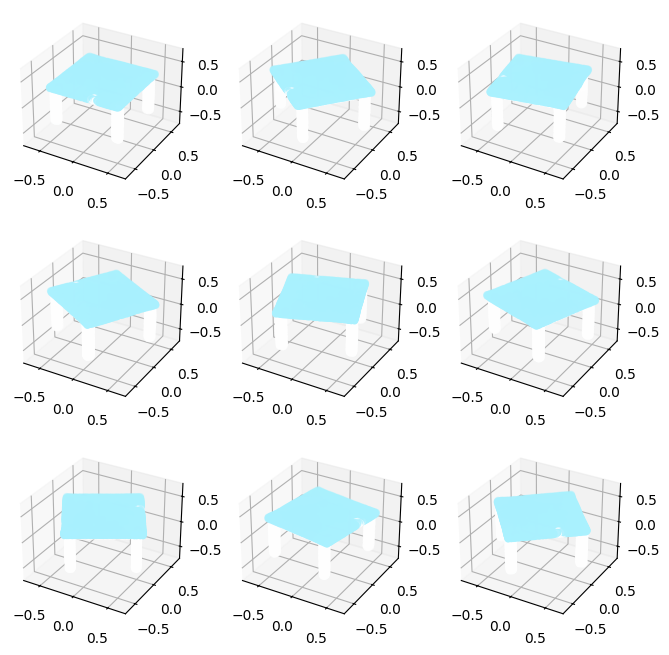

In [10]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [11]:
pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 12.5 MB/s eta 0:00:00


In [14]:
import trimesh
import numpy as np
point_coordinates = pc.coords
print("There are", len(point_coordinates), "points in the point cloud")

red_colors = pc.channels['R'] * 255
green_colors = pc.channels['G'] * 255
blue_colors = pc.channels['B'] * 255
colors = np.stack([red_colors, green_colors, blue_colors], axis=-1)
colors = colors.astype(np.uint8)

mesh = trimesh.points.PointCloud(point_coordinates, colors=colors)
mesh.export('output_model.stl')
mesh.export('output_model.obj')

There are 4096 points in the point cloud


'# https://github.com/mikedh/trimesh\nv -0.47487417 0.33149853 0.33553755 0.66274510 0.94117647 1.00000000\nv 0.35243049 -0.32363480 0.31753200 0.66666667 0.94509804 1.00000000\nv 0.30429399 0.10848016 0.31771287 0.66274510 0.94509804 1.00000000\nv 0.48054299 0.39468300 0.28702354 1.00000000 1.00000000 1.00000000\nv 0.44619706 0.18769836 0.33662754 0.66666667 0.94509804 1.00000000\nv 0.14517930 0.07454441 0.33767876 0.66274510 0.94509804 1.00000000\nv -0.41270599 -0.12614737 0.31660119 0.66274510 0.94509804 1.00000000\nv -0.42676607 0.42760420 0.31192657 0.71372549 0.95294118 1.00000000\nv -0.18021962 0.40600383 0.31755725 0.66666667 0.94509804 1.00000000\nv 0.32044739 0.46772271 0.31658947 0.66666667 0.94509804 1.00000000\nv -0.42797840 0.41097134 0.30013704 0.90196078 0.98039216 0.99607843\nv -0.29157755 -0.43702558 0.33529729 0.66274510 0.94509804 1.00000000\nv 0.25277624 -0.17181253 0.31764033 0.66666667 0.94509804 1.00000000\nv 0.01921777 -0.11787818 0.31772077 0.66274510 0.945098

In [15]:
#Run this code to download :)
from google.colab import files
files.download('output_model.stl')
files.download('output_model.obj')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>